# HW 8: Anomaly Detection and Recommender Systems

In this exercise, you will implement the anomaly detection algorithm and apply it to detect failing servers on a network. In the second part, you will use collaborative filtering to build a recommender system for movies. Before starting on the programming exercise, we strongly recommend watching the video lectures and completing the review questions for the associated topics.

In [1]:
import itertools as it
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import scipy.misc
import scipy.optimize as op
import scipy.io
import random
from IPython.display import display, Math, Latex
 
# set path
import os
os.chdir('%s/courses/coursera_ml008/hw8' % os.getenv('DST'))
print(os.getcwd())

# printing options 
np.set_printoptions(linewidth=250)
np.set_printoptions(precision=3)

# plotting options
%matplotlib inline
plt.rc('font'  , size=18)
plt.rc('figure', figsize=(10, 8))
plt.rc('axes'  , labelsize=22)
plt.rc('legend', fontsize=16)
plt.rc('figure', figsize=(10, 8))

C:\Users\J28976\Documents\Development\dst\courses\coursera_ml008\hw8


## 1 Anomaly Detection

In this exercise, you will implement an anomaly detection algorithm to detect anomalous behavior in server computers. The features measure the through-put (mb/s) and latency (ms) of response of each server. While your servers were operating, you collected $m = 307$ examples of how they were behaving, and thus have an unlabeled dataset $\{x^{(1)},\dots,x^{(m)}\}$. You suspect that the vast majority of these examples are “normal” (non-anomalous) examples of the servers operating normally, but there might also be some examples of servers acting anomalously within this dataset.

You will use a Gaussian model to detect anomalous examples in your dataset. You will first start on a 2D dataset that will allow you to visualize what the algorithm is doing. On that dataset you will fit a Gaussian distribution and then find values that have very low probability and hence can be considered anomalies. After that, you will apply the anomaly detection algorithm to a larger dataset with many dimensions. You will be using `ex8.m` for this part of the exercise.

The first part of `ex8.m` will visualize the dataset as shown in Figure 1.

<img src="fig1.png" width=500/>

In [2]:
ex8data1 = scipy.io.loadmat('ex8data1.mat')
ex8data1.keys()

['yval', '__header__', '__globals__', 'Xval', 'X', '__version__']

In [3]:
X     = ex8data1['X'   ]
X_val = ex8data1['Xval']
y_val = ex8data1['yval']
X.shape, X_val.shape, y_val.shape

((307L, 2L), (307L, 2L), (307L, 1L))

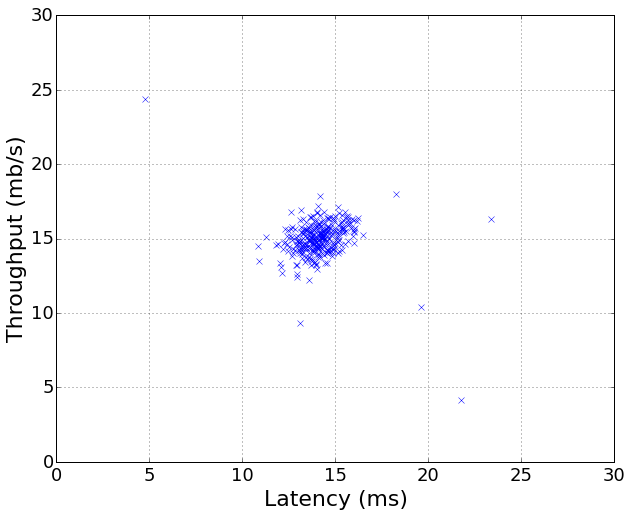

In [4]:
plt.plot(X[:,0], X[:,1], 'bx')
plt.grid()
plt.xlabel("Latency (ms)")
plt.ylabel("Throughput (mb/s)")
plt.axis([0, 30, 0, 30])
plt.show()

### 1.1 Gaussian Distribution

To perform anomaly detection, you will first need to fit a model to the data’s distribution.

Given a training set $\{x^{(1)},\dots,x^{(m)}\}$ (where $x^{(i)} \in \Bbb{R}^n$), you want to estimate the Gaussian distribution for each of the features $x_i$. For each feature $i = 1 \dots n$, you need to find parameters $\mu_i$ and $\sigma_i^2$ that fit the data in the $i$-th dimension $\{x_i^{(1)},\dots,x_i^{(m)}\}$ (the $i$-th dimension of each example).

The Gaussian distribution is given by

\begin{align}
P\left(x; \mu, \sigma^2\right) = \frac{1}{\sqrt{2 \pi \sigma^2}}e^{\frac{(x-\mu)^2}{2\sigma^2}},
\end{align}

where $\mu$ is the mean and $\sigma^2$ controls the variance.

For the multivariant Gaussian distribution:

\begin{align}
P\left(x; \mu, \Sigma\right) = \frac{1}{(2 \pi)^{\frac{n}{2}}|\Sigma|^{\frac{1}{2}}}\exp\left\{(x-\mu)^T\Sigma^{-1}(x-\mu)\right\},
\end{align}

### 1.2 Estimating parameters for a Gaussian

You can estimate the parameters, $(\mu_i, \sigma_i^2)$, of the $i$-th feature by using the following equations. To estimate the mean, you will use:

\begin{align}
\mu_i = \frac{1}{m}\sum_{j=1}^m x_i^{(j)}
\end{align}

and for the variance you will use:

\begin{align}
\sigma_i^2 = \frac{1}{m}\sum_{j=1}^m \left(x_i^{(j)} - \mu_i \right)^2
\end{align}

Your task is to complete the code in `estimateGaussian.m`. This function takes as input the data matrix $X$ and should output an $n$-dimension vector `mu` that holds the mean of all the $n$ features and another $n$-dimension vector `sigma2` that holds the variances of all the features. You can implement this using a for-loop over every feature and every training example (though a vectorized implementation might be more efficient; feel free to use a vectorized implementation if you prefer). Note that in Octave/MATLAB, the var function will (by default) use $\frac{1}{m-1}$ instead of $\frac{1}{m}$, when computing $\sigma^2$.

Once you have completed the code in `estimateGaussian.m`, the next part of `ex8.m` will visualize the contours of the fitted Gaussian distribution. You should get a plot similar to Figure 2. From your plot, you can see that most of the examples are in the region with the highest probability, while the anomalous examples are in the regions with lower probabilities.

<img src="fig2.png" width=700/>

In [5]:
def estimate_gaussian(X):
    mu     = np.mean(X, axis=0)
    sigma2 = np.var(X, axis=0)
    return mu, sigma2

In [6]:
mu, sigma2 = estimate_gaussian(X)
mu.shape, sigma2.shape

((2L,), (2L,))

In [7]:
def multivariate_gaussian(X, mu, sigma2):
    
    from numpy.linalg import matrix_rank as rank
    from numpy.linalg import det as det
    from numpy.linalg import pinv as pinv
    from numpy import pi, diagonal
    
    m, n   = X.shape
    Z      = (np.asmatrix(X)-np.asmatrix(mu)).T
    S      = np.asmatrix(np.diag(np.asarray(sigma2).reshape(n,)) if rank(sigma2)==1 else sigma2)
    assert(Z.T.shape==X.shape)
    assert(S.shape==(n,n))
    
    p = (1.0/((2*pi)**(0.5*n)*det(S)**(0.5)))*np.exp(-0.5*diagonal(Z.T*pinv(S)*Z))
    return p

In [8]:
p = multivariate_gaussian(X, mu, sigma2)
p.shape

(307L,)

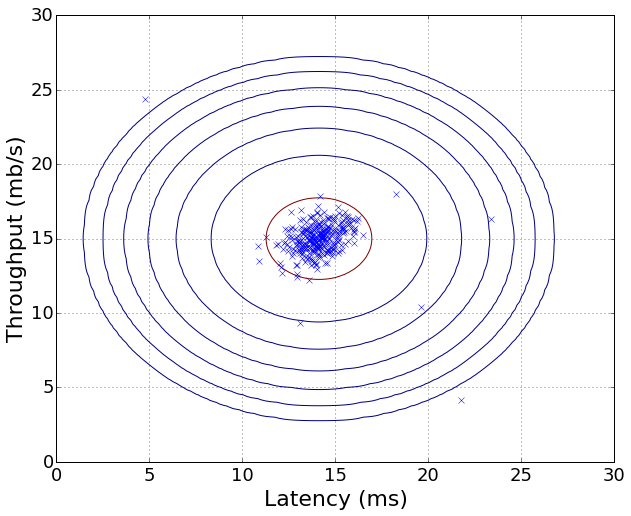

In [9]:
plt.plot(X[:,0], X[:,1], 'bx')
X1 = np.mgrid[0:35.5:0.25]
X2 = X1.copy()
X1, X2 = np.meshgrid( X1, X2 )

Z = multivariate_gaussian(np.c_[X1.T.ravel().T, X2.T.ravel().T], mu, sigma2)
Z = Z.reshape(np.shape(X1)[0], np.shape(X1)[1]).T
a = np.arange(-20, 0, 3)
b = np.ones_like(a, dtype=np.float)*10

plt.contour(X1, X2, Z, pow(b, a))
plt.axis([0, 30, 0, 30])
plt.grid()
plt.xlabel("Latency (ms)")
plt.ylabel("Throughput (mb/s)")
plt.show()

### 1.3 Selecting the Threshold, $\epsilon$

Now that you have estimated the Gaussian parameters, you can investigate which examples have a very high probability given this distribution and which examples have a very low probability. The low probability examples are more likely to be the anomalies in our dataset. One way to determine which examples are anomalies is to select a threshold based on a cross validation set. In this part of the exercise, you will implement an algorithm to select the threshold $\epsilon$ using the $F_1$ score on a cross validation set.

You should now complete the code in `selectThreshold.m`. For this, we will use a cross validation set $\{(x_{cv}^{(1)}, y_{cv}^{(1)}), \dots , (x_{cv}^{(m_{cv})}, y_{cv}^{(m_{cv})})\}$, where the label $y = 1$ corresponds to an anomalous example, and $y = 0$ corresponds to a normal example. For each cross validation example, we will compute $p(x^{(i)}_{cv})$. The vector of all of these probabilities $p(x^{(1)}_{cv}), \dots , p(x^{(m_{cv})})$ is passed to `selectThreshold.m` in the vector `pval`. The corresponding labels $y^{(1)}_{cv}, \dots , y^{(m_{cv})}_{cv}$ is passed to the same function in the vector `yval`.

The function `selectThreshold.m` should return two values; the first is the selected threshold $\epsilon$. If an example $x$ has a low probability $p(x) \lt \epsilon$, then it is considered to be an anomaly. The function should also return the $F_1$ score, which tells you how well you’re doing on finding the ground truth anomalies given a certain threshold. For many different values of $\epsilon$, you will compute the resulting $F_1$ score by computing how many examples the current threshold classifies correctly and incorrectly.

The $F_1$ score is computed using precision (*prec*) and recall (*rec*):

$$F_1 = \frac{2·prec·rec}{prec + rec},$$

You compute precision and recall by:
￼
$$prec = \frac{tp}{tp+fp}$$

$$rec = \frac{tp}{tp+fn}$$

￼￼where
  * $tp$ is the number of true positives: the ground truth label says it’s an anomaly and our algorithm correctly classified it as an anomaly.
  * $fp$ is the number of false positives: the ground truth label says it’s not an anomaly, but our algorithm incorrectly classified it as an anomaly.
  * $fn$ is the number of false negatives: the ground truth label says it’s an anomaly, but our algorithm incorrectly classified it as not being anomalous.

In the provided code `selectThreshold.m`, there is already a loop that will try many different values of $\epsilon$ and select the best $\epsilon$ based on the $F_1$ score. You should now complete the code in `selectThreshold.m`. You can implement the computation of the $F_1$ score using a for-loop over all the cross validation examples (to compute the values $tp$, $fp$, $fn$). You should see a value for epsilon of about `8.99e-05`.

**Implementation Note:** In order to compute $tp$, $fp$ and $fn$, you may be able to use a vectorized implementation rather than loop over all the examples. This can be implemented by `Octave/MATLAB’s` equality test between a vector and a single number. If you have several binary values in an $n$-dimensional binary vector $v \in {0,1}^n$, you can find out how many values in this vector are 0 by using: `sum(v == 0)`. You can also apply a logical and operator to such binary vectors. For instance, let `cvPredictions` be a binary vector of the size of your number of cross validation set, where the $i$-th element is 1 if your algorithm considers $x_{cv}^{(i)}$ an anomaly, and 0 otherwise. You can then, for example, compute the number of false positives using: `fp = sum((cvPredictions == 1) & (yval == 0))`.

Once you have completed the code in `selectThreshold.m`, the next step in ex8.m will run your anomaly detection code and circle the anomalies in the plot (Figure 3).

<img src="fig3.png" width=500/>

In [10]:
def select_threshold(y, p):

    epsilon   = 0.0
    F1        = 0.0
    step_size = (max(p)-min(p))/1000.0
    y         = y.ravel()
    
    for eps in np.arange(start=min(p), stop=max(p)+step_size, step=step_size):        
        pred = (p < eps)
        tp   = np.sum((pred==1)&(y==1), dtype=np.float)
        fp   = np.sum((pred==1)&(y==0), dtype=np.float)
        fn   = np.sum((pred==0)&(y==1), dtype=np.float)
        #tn   = np.sum((pred==0)&(y==0), dtype=np.float)
        
        prec = tp/(tp + fp)
        rec  = tp/(tp + fn)
        f1   = (2.0*prec*rec)/(prec + rec)
        
        if f1 > F1:
            F1      = f1
            epsilon = eps
            
    return epsilon, F1

In [11]:
p_val   = multivariate_gaussian(X_val, mu, sigma2)
eps, F1 = select_threshold(y_val, p_val)
eps, F1

(8.9908527792694959e-05, 0.87500000000000011)

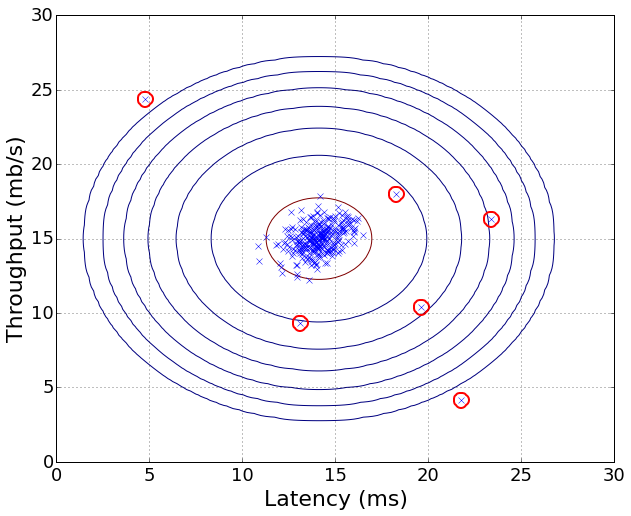

In [12]:
plt.plot(X[:,0], X[:,1], 'bx')
X1 = np.mgrid[0:35.5:0.25]
X2 = X1.copy()
X1, X2 = np.meshgrid(X1, X2)

Z = multivariate_gaussian(np.c_[X1.T.ravel().T, X2.T.ravel().T], mu, sigma2)
Z = Z.reshape(np.shape(X1)[0], np.shape(X1)[1]).T
a = np.arange(-20, 0, 3)
b = np.ones_like(a, dtype=np.float)*10
plt.contour(X1, X2, Z, pow(b, a))

X_out = X[p < eps]
plt.plot(
    X_out[:,0], 
    X_out[:,1], 'ro', lw=2, ms=15, mew=2, fillstyle='none'
)

plt.axis([0, 30, 0, 30])
plt.grid()
plt.xlabel("Latency (ms)")
plt.ylabel("Throughput (mb/s)")
plt.show()

### 1.4 High dimensional dataset

The last part of the script `ex8.m` will run the anomaly detection algorithm you implemented on a more realistic and much harder dataset. In this dataset, each example is described by 11 features, capturing many more properties of your compute servers.

The script will use your code to estimate the Gaussian parameters ($\mu_i$ and $\sigma_i^2$), evaluate the probabilities for both the training data $X$ from which you estimated the Gaussian parameters, and do so for the the cross-validation set `Xval`. Finally, it will use `selectThreshold` to find the best threshold $\epsilon$. You should see a value $\epsilon$ of about `1.38e-18`, and 117 anomalies found.

In [13]:
ex8data2 = scipy.io.loadmat('ex8data2.mat')
ex8data2.keys()

['yval', '__header__', '__globals__', 'Xval', 'X', '__version__']

In [14]:
X     = ex8data2['X'   ]
X_val = ex8data2['Xval']
y_val = ex8data2['yval']
X.shape, X_val.shape, y_val.shape

((1000L, 11L), (100L, 11L), (100L, 1L))

In [15]:
# train
mu, sigma2 = estimate_gaussian(X)
mu.shape, sigma2.shape

((11L,), (11L,))

In [16]:
# probabilities
p = multivariate_gaussian(X, mu, sigma2)
p.shape

(1000L,)

In [17]:
p_val   = multivariate_gaussian(X_val, mu, sigma2)
eps, F1 = select_threshold(y_val, p_val)
eps, F1

(1.3772288907613575e-18, 0.61538461538461542)

In [18]:
# anamolies found
np.sum(p < eps)

117

## 2 Recommender Systems

In this part of the exercise, you will implement the collaborative filtering learning algorithm and apply it to a dataset of movie ratings.2 This dataset consists of ratings on a scale of 1 to 5. The dataset has $n_u = 943$ users, and $n_m = 1682$ movies. For this part of the exercise, you will be working with the script `ex8_cofi.m`.

In the next parts of this exercise, you will implement the function `cofiCostFunc.m` that computes the collaborative fitlering objective function and gradient. After implementing the cost function and gradient, you will use `fmincg.m` to learn the parameters for collaborative filtering.

### 2.1 Movie ratings dataset

The first part of the script `ex8_cofi.m` will load the dataset `ex8_movies.mat`, providing the variables $Y$ and $R$ in your `Octave/MATLAB` environment.

The matrix $Y$ (a `num_movies` $\times$ `num_users` matrix) stores the ratings $y^{(i,j)}$ (from 1 to 5). The matrix $R$ is an binary-valued indicator matrix, where $R^{(i, j)} = 1$ if user $j$ gave a rating to movie $i$, and $R^{(i, j)} = 0$ otherwise. The objective of collaborative filtering is to predict movie ratings for the movies that users have not yet rated, that is, the entries with $R^{(i, j)} = 0$. This will allow us to recommend the movies with the highest predicted ratings to the user.

To help you understand the matrix $Y$, the script `ex8_cofi.m` will compute the average movie rating for the first movie (Toy Story) and output the average rating to the screen.

Throughout this part of the exercise, you will also be working with the matrices, $X$ and $\Theta$:

\begin{align}
X = 
\left[ 
\begin{array}{c}
-\ {(x^{(1)})}^T - \\
-\ {(x^{(2)})}^T - \\
\vdots  \\
-\ {(x^{(n_m)})}^T - \\
\end{array} 
\right]
, \qquad
\Theta = 
\left[ 
\begin{array}{c}
-\ {(\theta^{(1)})}^T - \\
-\ {(\theta^{(2)})}^T - \\
\vdots  \\
-\ {(\theta^{(n_u)})}^T - \\
\end{array} 
\right]
\end{align}

The $i$-th row of $X$ corresponds to the feature vector $x^{(i)}$ for the $i$-th movie, and the $j$-th row of $\Theta$ corresponds to one parameter vector $\theta^{(j)}$, for the $j$-th user. Both $x^{(i)}$ and $\theta^{(j)}$ are $n$-dimensional vectors. For the purposes of this exercise, you will use $n = 100$, and therefore, $x^{(i)} \in \Bbb{R}^{100}$ and $\theta^{(i)} \in \Bbb{R}^{100}$. Correspondingly, `X` is a $n_m \times 100$ matrix and `Theta` is a $n_u \times 100$ matrix.


In [19]:
ex8_movies = scipy.io.loadmat('ex8_movies.mat')
ex8_movies.keys()

['Y', 'R', '__version__', '__header__', '__globals__']

In [20]:
Y = ex8_movies['Y']
R = np.array(ex8_movies['R'], dtype=np.bool)
Y.shape, R.shape

((1682L, 943L), (1682L, 943L))

* $n_u$ = \# of users
* $n_m$ = \# of movies

In [21]:
n_m, n_u = Y.shape
n_u, n_m

(943L, 1682L)

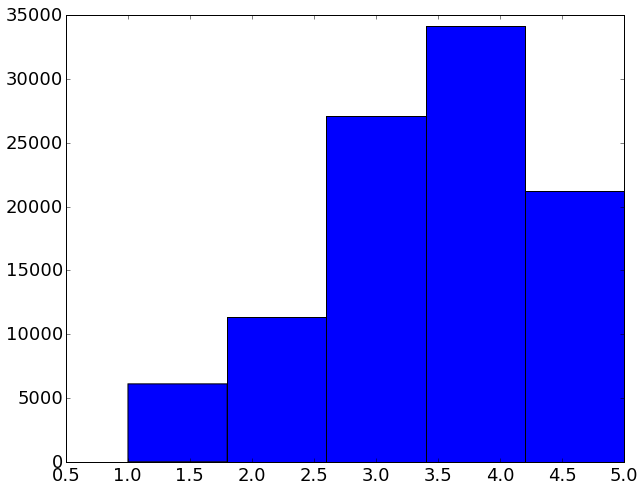

In [22]:
plt.hist(Y[R], bins=5)
plt.show()

In [23]:
print("Average rating for movie 1 (Toy Story): %f / 5\n\n" % Y[0, R[0,...]].mean())

Average rating for movie 1 (Toy Story): 3.878319 / 5




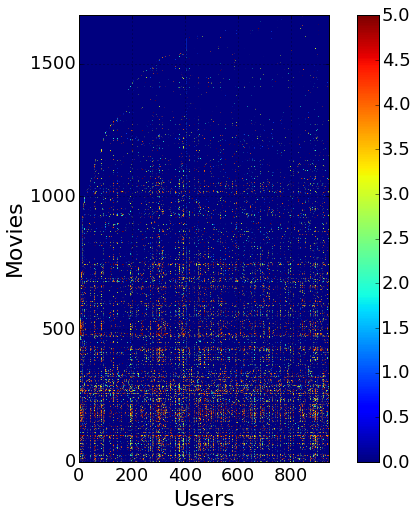

In [24]:
plt.imshow(Y, origin='lower')
plt.colorbar()
plt.ylabel('Movies')
plt.xlabel('Users')
plt.grid()
plt.show()

### 2.2 Collaborative filtering learning algorithm

Now, you will start implementing the collaborative filtering learning algorithm. You will start by implementing the cost function (without regularization).

The collaborative filtering algorithm in the setting of movie recommendations considers a set of $n$-dimensional parameter vectors $x^{(1)}, \dots, x^{(n_m)}$ and $\theta^{(1)}, \dots, \theta^{(n_u)}$, where the model predicts the rating for movie $i$ by user $j$ as $y^{(i,j)} = (\theta^{(j)})^T x^{(i)}$. Given a dataset that consists of a set of ratings produced by some users on some movies, you wish to learn the parameter vectors $x^{(1)}, \dots, x^{(n_m)},\theta^{(1)}, \dots, \theta^{(n_u)}$ that produce the best fit (minimizes the squared error).

You will complete the code in `cofiCostFunc.m` to compute the cost function and gradient for collaborative filtering. Note that the parameters to the function (i.e., the values that you are trying to learn) are `X` and `Theta`. In order to use an off-the-shelf minimizer such as `fmincg`, the cost function has been set up to unroll the parameters into a single vector params. You had previously used the same vector unrolling method in the neural networks programming exercise.

#### 2.2.1 Collaborative filtering cost function

The collaborative filtering cost function (without regularization) is given by

\begin{align}
J\left(x^{(1)}, \dots, x^{(n_m)},\theta^{(1)}, \dots, \theta^{(n_u)}\right) 
= \frac{1}{2} \sum_{(i,j):r(i,j)=1} \left((\theta^{(j)})^T x^{(i)} - y^{(i,j)}\right)^2
\end{align}

You should now modify `cofiCostFunc.m` to return this cost in the variable `J`. Note that you should be accumulating the cost for user $j$ and movie $i$ only if $R^{(i,j)} = 1$.

After you have completed the function, the script `ex8_cofi.m` will run your cost function. You should expect to see an output of `22.22`.

In [25]:
# load pre-trained weights (X, Theta, n_u, n_m, n_f)
ex8_movie_params = scipy.io.loadmat('ex8_movieParams.mat')
ex8_movie_params.keys()

['num_features',
 '__header__',
 '__globals__',
 'num_users',
 'X',
 'Theta',
 '__version__',
 'num_movies']

In [26]:
num_users    = ex8_movie_params['num_users'   ].ravel()[0]
num_movies   = ex8_movie_params['num_movies'  ].ravel()[0]
num_features = ex8_movie_params['num_features'].ravel()[0]
X            = ex8_movie_params['X'           ]
Theta        = ex8_movie_params['Theta'       ]
num_users, num_movies, num_features, X.shape, Theta.shape

(943, 1682, 10, (1682L, 10L), (943L, 10L))

In [27]:
def roll_params(x1, x2):
    x1 = np.asarray(x1)
    x2 = np.asarray(x2)
    return np.concatenate([x1.T.ravel(), x2.T.ravel()], axis=0) # i don't understand why the T

In [28]:
# test it
Z = roll_params(X, Theta)
Z.shape

(26250L,)

In [29]:
def unroll_params(z, shape1, shape2):
    size = shape1[0]*shape1[1]
    x1   = z[:size].reshape((shape1[1], shape1[0])).T
    x2   = z[size:].reshape((shape2[1], shape2[0])).T
    return x1, x2

In [30]:
# test it
n_f                    = 10
X_unroll, Theta_unroll = unroll_params(Z, (n_m, n_f), (n_u, n_f))
X_unroll.shape, np.array_equal(X_unroll, X), Theta_unroll.shape, np.array_equal(Theta_unroll, Theta)

((1682L, 10L), True, (943L, 10L), True)

In [31]:
def cost(Z, Y, R, n_f, lambda_param=0.0):
    n_m, n_u = Y.shape
    size     = n_m*n_f
    X, Theta = unroll_params(Z, (n_m, n_f), (n_u, n_f))
    X        = np.asmatrix(X)
    Theta    = np.asmatrix(Theta)
    J        = 0.5*np.sum(np.power((X*Theta.T)[R] - Y[R],2))
    J       += 0.5*lambda_param*(np.sum(np.power(Theta,2)) + np.sum(np.power(X,2)))
    return J

In [32]:
# test it
n_m_test   = 5
n_u_test   = 4
n_f_test   = 3
X_test     = X    [0:n_m_test, 0:n_f_test]
Theta_test = Theta[0:n_u_test, 0:n_f_test]
Y_test     = Y    [0:n_m_test, 0:n_u_test]
R_test     = R    [0:n_m_test, 0:n_u_test]
Z_test     = roll_params(X_test, Theta_test)

J = cost(Z_test, Y_test, R_test, n_f_test)
print('Cost at loaded parameters: %2.4f\n(this value should be about 22.22)\n'% J)

Cost at loaded parameters: 22.2246
(this value should be about 22.22)



In [33]:
cost_wrapper = lambda z: cost(z, Y_test, R_test, n_f_test, lambda_param=0.0)
cost_wrapper(Z_test)

22.224603725685672

#### 2.2.2 Collaborative filtering gradient

Now, you should implement the gradient (without regularization). Specifically, you should complete the code in `cofiCostFunc.m` to return the variables `X_grad` and `Theta_grad`. Note that `X_grad` should be a matrix of the same size as `X` and similarly, `Theta_grad` is a matrix of the same size as `Theta`. The gradients of the cost
function is given by:

\begin{align}
\frac{\partial J}{\partial x_k^{(i)}} &= \sum_{j:r(i,j)=1} \left((\theta^{(j)})^T x^{(i)} - y^{(i,j)}\right)\theta^{(j)}_k \\ 
\frac{\partial J}{\partial \theta_k^{(i)}} &= \sum_{i:r(i,j)=1} \left((\theta^{(j)})^T x^{(i)} - y^{(i,j)}\right)x^{(i)}_k
\end{align}

Note that the function returns the gradient for both sets of variables by unrolling them into a single vector. After you have completed the code to compute the gradients, the script `ex8_cofi.m` will run a gradient check (`checkCostFunction`) to numerically check the implementation of your gradients. If your implementation is correct, you should find that the analytical and numerical gradients match up closely.

In [34]:
def grad(Z, Y, R, n_f, lambda_param=0.0):
    n_m, n_u   = Y.shape
    size       = n_m*n_f
    X, Theta   = unroll_params(Z, (n_m, n_f), (n_u, n_f))
    X          = np.asmatrix(X)
    Theta      = np.asmatrix(Theta)
    dJ_dX      = np.multiply(R, X*Theta.T-Y)*Theta + lambda_param*X
    dJ_dTheta  = np.multiply(R, X*Theta.T-Y).T*X   + lambda_param*Theta
    dJ_dX      = np.asarray(dJ_dX)
    dJ_dTheta  = np.asarray(dJ_dTheta)
    return roll_params(dJ_dX, dJ_dTheta)

In [35]:
# test it
grad_J = grad(roll_params(X_test, Theta_test), Y_test, R_test, n_f_test)
dJ_dX, dJ_dTheta = unroll_params(grad_J, (n_m_test, n_f_test), (n_u_test, n_f_test))
dJ_dX.shape, dJ_dTheta.shape

((5L, 3L), (4L, 3L))

##### check it

A numerical calculation of the gradient should equal the analytical calculation.

In [36]:
def compute_numerical_grad(f, theta):
    theta   = np.asarray(theta)
    grad    = np.empty_like(theta)
    perturb = np.zeros_like(theta)
    eps     = 1e-4
    
    for i in np.arange(theta.size):
        perturb[i] = eps
        grad[i]    = (f(theta + perturb) - f(theta - perturb))/(2*eps)
        perturb[i] = 0
        
    return np.array(grad)

In [37]:
def check_cost_func(lambda_param = 0.0, seed=0):
    np.random.seed(seed)
    
    # fake parameters
    n_m     = 4
    n_u     = 5
    n_f     = 3
    X_t     = np.random.rand(n_m, n_f)
    Theta_t = np.random.rand(n_u, n_f)
    
    # fake measurements
    Y                               = X_t.dot(Theta_t.T)
    Y[np.random.rand(n_m, n_u)>0.5] = 0.0
    R                               = np.zeros_like(Y, dtype=np.bool)
    R[Y!=0]                         = 1

    # run grad checking
    X        = np.random.randn(n_m, n_f)
    Theta    = np.random.randn(n_u, n_f)
    Z        = roll_params(X, Theta)

    num_grad = compute_numerical_grad(lambda z: cost(z, Y, R, n_f, lambda_param), Z)
    ana_grad = grad(Z, Y, R, n_f, lambda_param)

    print('The below two columns you get should be very similar.')
    print('(Left-Your Numerical Gradient, Right-Analytical Gradient)\n')
    print(np.c_[num_grad, ana_grad])
    
    from numpy.linalg import norm
    diff = norm(num_grad-ana_grad)/norm(num_grad+ana_grad)
    print("""\
If your backpropagation implementation is correct, then 
the relative difference will be small (less than 1e-9).
Relative Difference: %g\n"""% diff)

In [38]:
check_cost_func()

The below two columns you get should be very similar.
(Left-Your Numerical Gradient, Right-Analytical Gradient)

[[-1.399 -1.399]
 [-4.392 -4.392]
 [ 0.311  0.311]
 [-0.914 -0.914]
 [-1.961 -1.961]
 [ 1.529  1.529]
 [-1.713 -1.713]
 [-0.614 -0.614]
 [-1.668 -1.668]
 [-1.469 -1.469]
 [-0.709 -0.709]
 [-0.517 -0.517]
 [-0.697 -0.697]
 [-0.949 -0.949]
 [ 7.683  7.683]
 [ 0.877  0.877]
 [-0.366 -0.366]
 [ 0.09   0.09 ]
 [-0.216 -0.216]
 [ 0.079  0.079]
 [ 1.628  1.628]
 [ 0.034  0.034]
 [-0.011 -0.011]
 [-1.582 -1.582]
 [-1.171 -1.171]
 [-2.395 -2.395]
 [-1.113 -1.113]]
If your backpropagation implementation is correct, then 
the relative difference will be small (less than 1e-9).
Relative Difference: 1.05909e-12



#### 2.2.3 Regularized cost function

The cost function for collaborative ltering with regularization is given by

\begin{align}
J\left(x^{(1)}, \dots, x^{(n_m)},\theta^{(1)}, \dots, \theta^{(n_u)}\right) 
= \frac{1}{2} \sum_{(i,j):r(i,j)=1} \left((\theta^{(j)})^T x^{(i)} - y^{(i,j)}\right)^2 +
\left(\frac{\lambda}{2}\sum_{j=1}^{n_u}\sum_{k=1}^n (\theta_k^{(j)})^2\right) +
\left(\frac{\lambda}{2}\sum_{i=1}^{n_m}\sum_{k=1}^n (x_k^{(i)})^2\right)
\end{align}

You should now add regularization to your original computations of the cost function, $J$. After you are done, the script `ex8_cofi.m` will run your regularized cost function, and you should expect to see a cost of about `31.34`.

In [39]:
J = cost(Z_test, Y_test, R_test, n_f_test, lambda_param=1.5)
print('Cost at loaded parameters: %2.4f\n(this value should be about 31.34)\n'% J)

Cost at loaded parameters: 31.3441
(this value should be about 31.34)



#### 2.2.4 Regularized gradient

Now that you have implemented the regularized cost function, you should proceed to implement regularization for the gradient. You should add to your implementation in `cofiCostFunc.m` to return the regularized gradient by adding the contributions from the regularization terms. Note that the gradients for the regularized cost function is given by:

\begin{align}
\frac{\partial J}{\partial x_k^{(i)}} &= \sum_{j:r(i,j)=1} \left((\theta^{(j)})^T x^{(i)} - y^{(i,j)}\right)\theta^{(j)}_k + \lambda x_k^{(i)}\\ 
\frac{\partial J}{\partial \theta_k^{(i)}} &= \sum_{i:r(i,j)=1} \left((\theta^{(j)})^T x^{(i)} - y^{(i,j)}\right)x^{(i)}_k + \lambda \theta_k^{(j)}
\end{align}

This means that you just need to add $\lambda x^{(i)}$ to the `X_grad(i,:)` variable described earlier, and add $\lambda \theta^{(j)}$ to the `Theta_grad(j,:)` variable described earlier.

After you have completed the code to compute the gradients, the script `ex8_cofi.m` will run another gradient check (`checkCostFunction`) to numerically check the implementation of your gradients.

In [40]:
check_cost_func(lambda_param=1.5)

The below two columns you get should be very similar.
(Left-Your Numerical Gradient, Right-Analytical Gradient)

[[-1.978 -1.978]
 [-7.292 -7.292]
 [ 0.102  0.102]
 [-2.403 -2.403]
 [-3.124 -3.124]
 [ 1.902  1.902]
 [-1.999 -1.999]
 [-0.953 -0.953]
 [-0.175 -0.175]
 [-1.516 -1.516]
 [-0.036 -0.036]
 [-2.999 -2.999]
 [-1.656 -1.656]
 [-2.113 -2.113]
 [ 9.363  9.363]
 [ 0.835  0.835]
 [-0.912 -0.912]
 [-0.63  -0.63 ]
 [-0.677 -0.677]
 [-0.608 -0.608]
 [ 3.842  3.842]
 [-0.984 -0.984]
 [ 0.456  0.456]
 [-2.132 -2.132]
 [-0.533 -0.533]
 [-1.425 -1.425]
 [-1.643 -1.643]]
If your backpropagation implementation is correct, then 
the relative difference will be small (less than 1e-9).
Relative Difference: 2.24855e-12



### 2.3 Learning movie recommendations

After you have finished implementing the collaborative filtering cost function and gradient, you can now start training your algorithm to make movie recommendations for yourself. In the next part of the `ex8_cofi.m` script, you can enter your own movie preferences, so that later when the algorithm runs, you can get your own movie recommendations! We have filled out some values according to our own preferences, but you should change this according to your own tastes. The list of all movies and their number in the dataset can be found listed in the file `movie_idx.txt`.

**Note**: I manually modified the file `movie_idx.txt` to be tab seperated.

In [41]:
movie_df = pd.read_csv('movie_ids.txt', sep='\t', header=None, names=['idx', 'title'])
movie_df.head()

,idx,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


#### 2.3.1 Recommendations

`Top recommendations for you:
Predicting rating 9.0 for movie Titanic (1997)
Predicting rating 8.9 for movie Star Wars (1977)
Predicting rating 8.8 for movie Shawshank Redemption, The (1994)
Predicting rating 8.5 for movie As Good As It Gets (1997)
Predicting rating 8.5 for movie Good Will Hunting (1997)
Predicting rating 8.5 for movie Usual Suspects, The (1995)
Predicting rating 8.5 for movie Schindler's List (1993)
Predicting rating 8.4 for movie Raiders of the Lost Ark (1981)
Predicting rating 8.4 for movie Empire Strikes Back, The (1980)
Predicting rating 8.4 for movie Braveheart (1995)`

`Original ratings provided:
Rated 4 for Toy Story (1995)
Rated 3 for Twelve Monkeys (1995)
Rated 5 for Usual Suspects, The (1995)
Rated 4 for Outbreak (1995)
Rated 5 for Shawshank Redemption, The (1994)
Rated 3 for While You Were Sleeping (1995)
Rated 5 for Forrest Gump (1994)
Rated 2 for Silence of the Lambs, The (1991)
Rated 4 for Alien (1979)
Rated 5 for Die Hard 2 (1990)
Rated 5 for Sphere (1998)`

After the additional ratings have been added to the dataset, the script will proceed to train the collaborative filtering model. This will learn the parameters `X` and `Theta`. To predict the rating of movie $i$ for user $j$, you need to compute $(\theta^{(j)})^T x^{(i)}$. The next part of the script computes the ratings for all the movies and users and displays the movies that it recommends (Figure 4), according to ratings that were entered earlier in the script. Note that you might obtain a difierent set of the predictions due to difierent random initializations.

In [42]:
def normalize_ratings(Y, R):
    m, n = Y.shape
    Y_mean = np.empty((m, 1))
    Y_norm = np.empty_like(Y)
    for i in range(m):
        idx           = np.where(R[i]==1)
        Y_mean[i]      = np.mean(Y[i,idx])
        Y_norm[i, idx] = Y[i, idx] - Y_mean[i]
    return Y_norm, Y_mean

In [43]:
my_ratings = np.zeros((Y.shape[0], 1))
my_ratings[0  ] = 4
my_ratings[97 ] = 2
my_ratings[6  ] = 3
my_ratings[11 ] = 5
my_ratings[53 ] = 4
my_ratings[63 ] = 5
my_ratings[65 ] = 3
my_ratings[68 ] = 5
my_ratings[182] = 4
my_ratings[225] = 5
my_ratings[354] = 5

In [44]:
Y = np.c_[my_ratings   , Y]
R = np.c_[my_ratings!=0, R]
Y.shape, R.shape

((1682L, 944L), (1682L, 944L))

In [45]:
Y_norm, Y_mean = normalize_ratings(Y, R)
Y_norm.shape, Y_mean.shape

((1682L, 944L), (1682L, 1L))

In [46]:
n_m, n_u = Y.shape
n_f      = 10

In [47]:
X     = np.random.randn(n_m, n_f)
Theta = np.random.randn(n_u, n_f)
X.shape, Theta.shape

((1682L, 10L), (944L, 10L))

In [48]:
Z_init = roll_params(X, Theta)
Z_init.shape

(26260L,)

In [49]:
# initial cost
J_init = cost(Z_init, Y, R, n_f, lambda_param=0.0)
print('initial cost: %f'%J_init)

initial cost: 1189047.622874


In [50]:
# train the model
def train(Y, R, n_f, lambda_param=0.0, max_iter=50):
    
    n_m, n_u = Y.shape
    X_init     = np.random.randn(n_m, n_f)
    Theta_init = np.random.randn(n_u, n_f)
    Z_init     = roll_params(X_init, Theta_init)

    # optimize
    op_result = op.minimize(
        fun=cost, 
        jac=grad, 
        x0=Z_init, 
        args=(Y, R, n_f, lambda_param), 
        method='CG', 
        options={'maxiter': max_iter, 'disp': True}
    )
    print(op_result)
    
    X, Theta = unroll_params(op_result.x, X_init.shape, Theta_init.shape)   
    return X, Theta

In [51]:
X, Theta = train(Y, R, n_f, lambda_param=10.0, max_iter=100)
X.shape, Theta.shape

         Current function value: 72008.377564
         Iterations: 100
         Function evaluations: 161
         Gradient evaluations: 161
  status: 1
 success: False
    njev: 161
    nfev: 161
     fun: 72008.37756412002
       x: array([-1.363, -0.76 , -0.671, ...,  0.028, -0.133, -0.577])
 message: 'Maximum number of iterations has been exceeded.'
     jac: array([-0.332,  0.127,  0.005, ..., -0.071,  0.115, -0.241])


((1682L, 10L), (944L, 10L))

In [52]:
my_pred = X.dot(Theta.T)[:, 0:1] + Y_mean
my_pred.shape

(1682L, 1L)

In [53]:
idx     = my_pred.argsort(axis=0)[::-1]
my_pred = my_pred[idx]
my_pred.shape

(1682L, 1L, 1L)

In [54]:
print('Rop recommendations for you:')
for i in range(0, 10):
    j = idx[i, 0]
    print "Predicting rating %.1f for movie %s" % (my_pred[j], movie_df.title[j])

Rop recommendations for you:
Predicting rating 7.4 for movie Star Wars (1977)
Predicting rating 6.4 for movie Titanic (1997)
Predicting rating 7.3 for movie Shawshank Redemption, The (1994)
Predicting rating 6.8 for movie Raiders of the Lost Ark (1981)
Predicting rating 6.4 for movie Schindler's List (1993)
Predicting rating 6.5 for movie Good Will Hunting (1997)
Predicting rating 7.9 for movie Usual Suspects, The (1995)
Predicting rating 7.0 for movie Godfather, The (1972)
Predicting rating 6.9 for movie Empire Strikes Back, The (1980)
Predicting rating 7.7 for movie Braveheart (1995)


In [55]:
print('Original ratings provided:')
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print "Rated %d for movie %s" % (my_ratings[i], movie_df.title[i])

Original ratings provided:
Rated 4 for movie Toy Story (1995)
Rated 3 for movie Twelve Monkeys (1995)
Rated 5 for movie Usual Suspects, The (1995)
Rated 4 for movie Outbreak (1995)
Rated 5 for movie Shawshank Redemption, The (1994)
Rated 3 for movie While You Were Sleeping (1995)
Rated 5 for movie Forrest Gump (1994)
Rated 2 for movie Silence of the Lambs, The (1991)
Rated 4 for movie Alien (1979)
Rated 5 for movie Die Hard 2 (1990)
Rated 5 for movie Sphere (1998)
